TODO
create venv to wrap up all installation programatically
set the experiment name in mlflow dynamically
update teh target name dynamic after db repo integration

In [ ]:
# ⚙️ Install required packages in the notebook itself
# !pip install --quiet --upgrade pip
!pip install mlflow scikit-learn
!pip install pandas
!pip install numpy
!pip install jupyter
!pip install shap


In [ ]:
!pip install scikit-learn

In [ ]:
!pip uninstall numpy
!pip install numpy --force-reinstall --upgrade
!pip uninstall shap
!pip install shap --upgrade
!pip install mkl

In [69]:
import git  
import mlflow
from mlflow import MlflowClient
import time
import psutil
import platform
import sklearn
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import json
import os
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    precision_score, recall_score, f1_score, roc_curve
)
import shap
import seaborn as sns
import matplotlib.pyplot as plt
os.environ["MLFLOW_SYSTEM_METRICS_ENABLED"] = "true"


In [70]:
# Set experiment name
# ============================
# 🔧 Configuration
# ============================
pproject_dir = os.getcwd()
tracking_dir = os.path.join(project_dir, "mlruns")
mlflow.set_tracking_uri("mlrunlogs/mlflow.db")  # Setting the MLflow tracking URI
print("Tracking URI set to:", mlflow.get_tracking_uri())

mlflow.set_experiment("RandomForest-Iris-CSV")

Tracking URI set to: mlrunlogs/mlflow.db


<Experiment: artifact_location='file:///C:/Users/reema/OneDrive/Dokumente/Provenance_tracking_thesis/Provenence-Tracking-Thesis-Research/notebooks/RQ_notebooks/mlrunlogs/mlflow.db/350083769514222255', creation_time=1744653654888, experiment_id='350083769514222255', last_update_time=1744653654888, lifecycle_stage='active', name='RandomForest-Iris-CSV', tags={}>

In [71]:
# ============================
# 📥 Load Data from CSV
# ============================
# Read data from CSV file
df = pd.read_csv("C:/Users/reema/OneDrive/Dokumente/Provenance_tracking_thesis/Provenence-Tracking-Thesis-Research/data/Iris.csv")
# Use the last column as the target variable
X = df.iloc[:, :-1]  # All columns except the last one are features
y = df.iloc[:, -1]   # The last column is the target

# Create a dataset object with mlflow.data
dataset = mlflow.data.from_pandas(df, name="Iris Dataset")

In [72]:
# Dataset Metadata to be logged 'TODO_update based on DBREPO LOG
dataset_metadata = {
    "dataset_name": "Iris Dataset",
    "dataset_version": "1.0.0",  # or use a Git commit hash or timestamp
    "dataset_source_url_or_path": "C:/Users/reema/OneDrive/Dokumente/Provenance_tracking_thesis/Provenence-Tracking-Thesis-Research/data/Iris.csv",
    "dataset_size_bytes": os.path.getsize("C:/Users/reema/OneDrive/Dokumente/Provenance_tracking_thesis/Provenence-Tracking-Thesis-Research/data/Iris.csv"),
    "dataset_shape": f"{df.shape[0]} x {df.shape[1]}",
    "dataset_format": "CSV",
    "feature_names": list(X.columns),
    "feature_types": [str(X[col].dtype) for col in X.columns],
    "target_column": y.name,
    "class_distribution": y.value_counts().to_dict(),
    "missing_value_strategy": "None",  # Update based on your strategy (e.g., imputation or dropping missing values)
    "scaling_encoding_steps": "None",  # Update if any scaling or encoding is performed
    "data_split_method": "Train-test split (80-20)",
    "data_random_seed": 42,  # Random state for reproducibility
    "preprocessing_pipeline": "None",  # Or provide a path or summary of preprocessing steps
}

In [73]:
# Capture Git commit hash
repo_dir = "C:/Users/reema/OneDrive/Dokumente/Provenance_tracking_thesis/Provenence-Tracking-Thesis-Research"
repo = git.Repo(repo_dir)
commit_hash = repo.head.object.hexsha
print(f"Git commit: {commit_hash}")
# Log system information
python_version = sys.version
platform_info = platform.system()

print(f"Git commit: {commit_hash}")
print(f"Python version: {python_version}")
print(f"Platform: {platform_info}")
# 🧠 MLflow Autologging
mlflow.autolog(log_input_examples=True, log_model_signatures=True)

2025/04/14 22:10:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


Git commit: 8f07816bad4ec2acee3ef8dbb7370db46c6d172b
Git commit: 8f07816bad4ec2acee3ef8dbb7370db46c6d172b
Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Platform: Windows


2025/04/14 22:10:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/14 22:10:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Model 'RandomForest_IrisDataset_v1.0.0' already exists. Registering a new version...


2025/04/14 22:10:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RandomForest_IrisDataset_v1.0.0' already exists. Creating a new version of this model...
Created version '7' of model 'RandomForest_IrisDataset_v1.0.0'.
C:\Users\reema\AppData\Local\Temp\ipykernel_14504\2059064886.py:38: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  model_versions = client.get_latest_versions(model_name)


✅ Model logged and registered as: RandomForest_IrisDataset_v1.0.0, Version: 7


C:\Users\reema\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\reema\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
C:\Users\reema\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:761: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


Run logged with ID: 21017b4179494ef49706508240ab526e


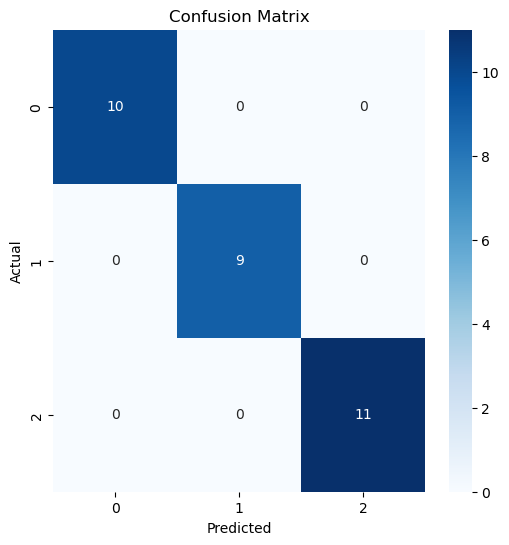

<Figure size 640x480 with 0 Axes>

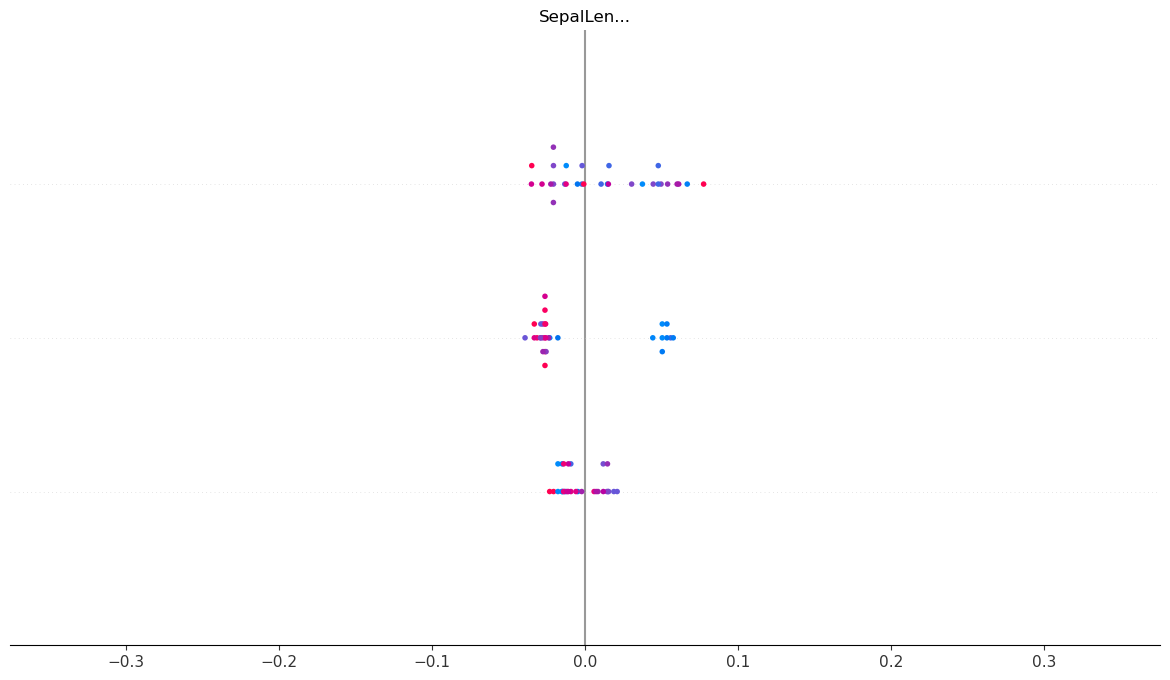

In [74]:
# 🧠 MLflow Autologging Enabled
mlflow.autolog(log_input_examples=True, log_model_signatures=True)
# ============================
# 🚀 Start MLflow Run
# ============================

# ✅ Logging Dataset Metadata
with mlflow.start_run() as run:
    # Track system metrics manually
    cpu_before = psutil.cpu_percent(interval=1)
    mem_before = psutil.virtual_memory().percent
    training_time_start = time.time()

    # Log dataset metadata
    mlflow.log_params(dataset_metadata)

    # Define dynamic model name
    model_name = f"RandomForest_{dataset_metadata['dataset_name'].replace(' ', '')}_v{dataset_metadata['dataset_version']}"

    # Use the MLflow client to check if the model already exists
    client = MlflowClient()
    model_registered = False

    for model in client.search_registered_models():
        if model.name == model_name:
            model_registered = True
            break

    # Register the model or update with a new version
    if model_registered:
        print(f"Model '{model_name}' already exists. Registering a new version...")
        mlflow.sklearn.log_model(model, artifact_path="model", registered_model_name=model_name)
    else:
        print(f"Registering new model '{model_name}'...")
        mlflow.sklearn.log_model(model, artifact_path="model", registered_model_name=model_name)

    # Fetch the model version
    model_versions = client.get_latest_versions(model_name)
    latest_version = model_versions[0].version if model_versions else None

    # Log the model version and other details
    mlflow.log_param("model_name", model_name)
    mlflow.log_param("model_version", latest_version)
    mlflow.log_param("all_model_version", model_versions)

    print(f"✅ Model logged and registered as: {model_name}, Version: {latest_version}")

    # Save input data as CSV and log it
    Xy = X.copy()
    Xy["target"] = y
    data_path = "iris_dataset.csv"
    Xy.to_csv(data_path, index=False)
    mlflow.log_artifact(data_path, artifact_path="input_data")


    # Model training
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
    except ValueError as e:
        error_code = 1001  # Example error code
        mlflow.log_param("error_code", error_code)  # Log the error code
        error_message = str(e)
        mlflow.log_param("error_message", error_message)  # Log the specific error message
        with open("error_log.txt", "w") as error_file:
            error_file.write(f"Error Code: {error_code}\nError Message: {error_message}")
        mlflow.log_artifact("error_log.txt")  # Log the error log file
        print(f"Error Code: {error_code}, Message: {error_message}")

    
    training_time_end = time.time()
    training_time = training_time_end - training_time_start
    cpu_after = psutil.cpu_percent(interval=1)
    mem_after = psutil.virtual_memory().percent

    # Log base params
    mlflow.log_params({
        "model_type": type(model).__name__,
        "model_library": "scikit-learn",
        "dataset_source": "DBrepo",
        "training_time_start": training_time_start,
        "training_time_end": training_time_end
    })

    # Save model metadata
    model_metadata = {
        "model_type": "RandomForestClassifier",
        "commit_hash": commit_hash,
        "experiment_id": mlflow.active_run().info.experiment_id,
        "training_timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "training_error": "None",
        "training_dataset_version": "1.0.0",
        "testing_dataset_version": "1.0.0",
        "python_version": python_version,
        "platform": platform_info
    }
    # Evaluation
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba, multi_class="ovr")
    mlflow.log_metrics({
        "accuracy": acc,
        "roc_auc": auc,
        "precision": precision_score(y_test, y_pred, average='macro'),
        "recall": recall_score(y_test, y_pred, average='macro'),
        "f1_score": f1_score(y_test, y_pred, average='macro')
    })
    # Log full model hyperparameters
    mlflow.log_params(model.get_params())

    # Log metrics
    mlflow.log_metrics({
        "cpu_before": cpu_before,
        "cpu_after": cpu_after,
        "mem_before": mem_before,
        "mem_after": mem_after,
        "training_duration_seconds": training_time
    })
    mlflow.log_param("python_version", python_version)
    mlflow.log_param("platform", platform_info)
    mlflow.log_param("commit_hash", commit_hash)
    mlflow.log_param("training_timestamp", time.strftime("%Y-%m-%d %H:%M:%S"))
    mlflow.log_param("training_error", "None")


    mlflow.log_params({
        "model": "RandomForestClassifier",
        "n_estimators": 100,
        "dataset_source": "DBrepo"
    })


    # Confusion Matrix
    confusion = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    cm_path = "confusion_matrix.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1], pos_label=1)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    roc_path = "roc_curve.png"
    plt.savefig(roc_path)
    mlflow.log_artifact(roc_path)

    # SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, show=False)
    shap_path = "shap_summary.png"
    plt.savefig(shap_path)
    mlflow.log_artifact(shap_path)

    # Feature importance
    feat_imp = pd.DataFrame({
        "Feature": X.columns,
        "Importance": model.feature_importances_
    }).sort_values(by="Importance", ascending=False)
    feat_path = "feature_importance.csv"
    feat_imp.to_csv(feat_path, index=False)
    mlflow.log_artifact(feat_path)

    # Save and log dataset as artifact
    Xy = X.copy()
    Xy["target"] = y
    data_path = "iris_dataset.csv"
    Xy.to_csv(data_path, index=False)
    mlflow.log_artifact(data_path, artifact_path="input_data")

    # Log input and output schema
    input_schema = X.dtypes.astype(str).to_dict()
    with open("input_schema.json", "w") as f:
        json.dump(input_schema, f)
    mlflow.log_artifact("input_schema.json")

    output_schema = {
        "output_type": str(type(y_pred[0])),
        "classes": model.classes_.tolist()
    }
    with open("output_schema.json", "w") as f:
        json.dump(output_schema, f)
    mlflow.log_artifact("output_schema.json")

    # Git commit and push after successful run
    repo.git.add(A=True)  # Add all changes to git
    repo.index.commit(f"Model training and logging complete: {commit_hash}")
    repo.remotes.origin.push()  # Push to the remote repository

    # Log model version and Git commit after successful run
    model_uri = f"runs:/{run.info.run_id}/random_forest_model"
    print(f"Run logged with ID: {run.info.run_id}")
    mlflow.end_run()

In [78]:
import requests

# GitHub repository details
owner = "reema-dass26"
repo = "Provenence-Tracking-Thesis-Research"
token = "REMOVED_SECRET"  # A GitHub token with read access to public repositories

# GitHub API URL to get forks
url = f"https://api.github.com/repos/{owner}/{repo}/forks"

# Set headers with authorization token
headers = {
    "Authorization": f"token {token}"
}

# Make the GET request to fetch the forks
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    forks = response.json()
    for fork in forks:
        print(f"Forked by: {fork['owner']['login']} - {fork['html_url']}")
else:
    print(f"Failed to fetch forks: {response.status_code}")


Forked by: reemagdass - https://github.com/reemagdass/Provenence-Tracking-Thesis-Research


In [82]:
# import requests

# # GitHub repository details
# owner = "reema-dass26"
# repo = "Provenence-Tracking-Thesis-Research"
# token = "REMOVED_SECRET"  # GitHub token with 'repo' or 'public_repo' scope

# # Headers for authentication
# headers = {
#     "Authorization": f"token {token}",
#     "Accept": "application/vnd.github.v3+json"
# }

# # Step 1: Get all forks of the repo
# forks_url = f"https://api.github.com/repos/{owner}/{repo}/forks"
# response = requests.get(forks_url, headers=headers)

# if response.status_code == 200:
#     forks = response.json()
    
#     for fork in forks:
#         forked_by = fork['owner']['login']
#         fork_url = fork['html_url']
#         print(f"Forked by: {forked_by} - {fork_url}")

#         # Step 2: Create an issue in the original repo to notify the forker
#         issue_url = f"https://api.github.com/repos/{owner}/{repo}/issues"
#         issue_data = {
#             "title": f"Repository Update Notification for @{forked_by}",
#             "body": (
#                 f"Hi @{forked_by},\n\n"
#                 "We noticed you have forked this repository. "
#                 "Just wanted to notify you that there have been recent updates. "
#                 "Please pull the latest changes to stay up to date.\n\n"
#                 "Let us know if you face any issues! 😊"
#             )
#         }

#         issue_response = requests.post(issue_url, headers=headers, json=issue_data)

#         if issue_response.status_code == 201:
#             print(f"✅ Issue successfully created to notify @{forked_by}")
#         else:
#             print(f"❌ Failed to create issue for @{forked_by}: {issue_response.status_code} - {issue_response.text}")
# else:
#     print(f"❌ Failed to fetch forks: {response.status_code} - {response.text}")


Forked by: reemagdass - https://github.com/reemagdass/Provenence-Tracking-Thesis-Research
❌ Failed to create issue for @reemagdass: 404 - {"message":"Not Found","documentation_url":"https://docs.github.com/rest/issues/issues#create-an-issue","status":"404"}


In [84]:
# import requests

# # Basic test issue creation
# owner = "reema-dass26"
# repo = "Provenence-Tracking-Thesis-Research"
# token = "REMOVED_SECRET"

# headers = {
#     "Authorization": f"token {token}",
#     "Accept": "application/vnd.github.v3+json"
# }

# url = f"https://api.github.com/repos/{owner}/{repo}/issues"
# data = {
#     "title": "Test Issue from Script",
#     "body": "This is a test issue to check access permissions."
# }

# response = requests.post(url, headers=headers, json=data)

# print(response.status_code)
# print(response.json())


404
{'message': 'Not Found', 'documentation_url': 'https://docs.github.com/rest/issues/issues#create-an-issue', 'status': '404'}


In [92]:
# import requests

# # GitHub authentication
# token = "REMOVED_SECRET"
# owner = "reema-dass26"
# repo = "Provenence-Tracking-Thesis-Research"

# # Headers for authentication
# headers = {
#     "Authorization": f"token {token}",
#     "Accept": "application/vnd.github+json"
# }

# # Step 1: Fetch all forks
# forks_url = f"https://api.github.com/repos/{owner}/{repo}/forks"
# response = requests.get(forks_url, headers=headers)

# if response.status_code == 200:
#     forks = response.json()
#     usernames = [f"@{fork['owner']['login']}" for fork in forks]

#     if not usernames:
#         print("No forks found.")
#     else:
#         mention_line = ", ".join(usernames)
#         title = "🔔 Repository Update Notification"
#         body = f"Hi {mention_line},\n\nThere have been some updates or changes to the main repository. Please pull the latest changes or check if any part is broken.\n\nThanks for contributing! ❤️"

#         # Step 2: Create an issue on your repo with mentions
#         issues_url = f"https://api.github.com/repos/{owner}/{repo}/issues"
#         issue_data = {
#             "title": title,
#             "body": body,
#         }

#         create_issue = requests.post(issues_url, headers=headers, json=issue_data)
#         if create_issue.status_code == 201:
#             print("✅ Issue created successfully and users notified!")
#         else:
#             print(f"❌ Failed to create issue: {create_issue.status_code} - {create_issue.text}")

# else:
#     print(f"❌ Failed to fetch forks: {response.status_code} - {response.text}")


❌ Failed to create issue: 404 - {"message":"Not Found","documentation_url":"https://docs.github.com/rest/issues/issues#create-an-issue","status":"404"}


In [97]:
# import requests

# # Authentication for user filing issue (must have read/write access to
# # repository to add issue to)
# TOKEN = 'REMOVED_SECRET'  # Use your GitHub Personal Access Token
# USERNAME = 'reema-dass26'

# # The repository to add this issue to
# REPO_OWNER = 'reema-dass26'  # Your GitHub username or organization
# REPO_NAME = 'Provenence-Tracking-Thesis-Research'  # Your repository name

# def make_github_issue(title, body=None, assignee=None, milestone=None, labels=None):
#     '''Create an issue on github.com using the given parameters.'''
#     # URL to create issues via POST
#     url = f'https://api.github.com/repos/{REPO_OWNER}/{REPO_NAME}/issues'
    
#     # Create the headers including the token for authentication
#     headers = {
#         'Authorization': f'token {TOKEN}',
#         'Accept': 'application/vnd.github+json'
#     }
    
#     # Create our issue
#     issue = {
#         'title': title,
#         'body': body,
#         'assignee': assignee,
#         'milestone': milestone,
#         'labels': labels
#     }

#     # Add the issue to our repository
#     r = requests.post(url, headers=headers, json=issue)

#     # Check if the request was successful
#     if r.status_code == 201:
#         print(f'Successfully created Issue "{title}"')
#     else:
#         print(f'Could not create Issue "{title}"')
#         print('Response:', r.content)

# # Example usage
# make_github_issue('Issue Title', 'Body text', 'assigned_user', 3, ['bug'])


Could not create Issue "Issue Title"
Response: b'{"message":"Not Found","documentation_url":"https://docs.github.com/rest/issues/issues#create-an-issue","status":"404"}'


In [ ]:
#     # Track system metrics manually
#     cpu_before = psutil.cpu_percent(interval=1)
#     mem_before = psutil.virtual_memory().percent
#     training_time_start  = time.time()


#     # Log dataset metadata
#     mlflow.log_params(dataset_metadata)


#      # Define dynamic model name
#     model_name = f"RandomForest_{dataset_metadata['dataset_name'].replace(' ', '')}_v{dataset_metadata['dataset_version']}"

#     # Use the MLflow client to check if the model already exists
#     client = MlflowClient()
#      # Check if model already exists
#     existing_models = client.search_registered_models()
#     model_registered = False

#     for model in existing_models:
#         if model.name == model_name:
#             model_registered = True
#             break

#     # Register the model or update with a new version
#     if model_registered:
#         print(f"Model '{model_name}' already exists. Registering a new version...")
#         mlflow.sklearn.log_model(
#             sk_model=model,
#             artifact_path="model",
#             registered_model_name=model_name
#         )
#     else:
#         print(f"Registering new model '{model_name}'...")
#         mlflow.sklearn.log_model(
#             sk_model=model,
#             artifact_path="model",
#             registered_model_name=model_name
#         )
#          # Fetch the model version after logging it
#     model_versions = client.get_latest_versions(model_name)
#     latest_version = model_versions[0].version if model_versions else None
#     mlflow.log_param("model_name", model_name)  
#     mlflow.log_param("model_version", latest_version)
#     mlflow.log_param("all_model_version", model_versions)  


#     print(f"✅ Model logged and registered as: {model_name}, Version: {latest_version}")

#     print(f"✅ Model logged and registered as: {model_name}")

#     # Save input data as CSV and log it
#     Xy = X.copy()
#     Xy["target"] = y
#     data_path = "iris_dataset.csv"
#     Xy.to_csv(data_path, index=False)
#     mlflow.log_artifact(data_path, artifact_path="input_data")

#    # Model training
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     model = RandomForestClassifier(n_estimators=100, random_state=42)
#     model.fit(X_train, y_train)
    
#     training_time_end = time.time()
#     training_time = training_time_end - training_time_start
#     cpu_after = psutil.cpu_percent(interval=1)
#     mem_after = psutil.virtual_memory().percent

    
#      # Log base params
#     mlflow.log_params({
#         "model_type": type(model).__name__,
#         "model_library": "scikit-learn",
#         "dataset_source": "DBrepo",
#         "training_time_start": training_time_start,
#         "training_time_end": training_time_end
#     })
#       # Save the model metadata 👈 **New**
#     model_metadata = {
#         "model_type": "RandomForestClassifier",
#         "commit_hash": commit_hash,
#         "experiment_id": mlflow.active_run().info.experiment_id,
#         "training_timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
#         "training_error": "None",
#         "training_dataset_version": "1.0.0",
#         "testing_dataset_version": "1.0.0",
#         "python_version": python_version,
#         "platform": platform_info
#     }


#      # Log full model hyperparameters
#     mlflow.log_params(model.get_params())

#     # Log metrics
#     mlflow.log_metrics({
#         "cpu_before": cpu_before,
#         "cpu_after": cpu_after,
#         "mem_before": mem_before,
#         "mem_after": mem_after,
#         "training_duration_seconds": training_time
#     })
#     # Log environment details 👈 **New**
#     mlflow.log_param("python_version", python_version)
#     mlflow.log_param("platform", platform_info)
#     mlflow.log_param("commit_hash", commit_hash)
#     # Log the training timestamp 👈 **New**
#     mlflow.log_param("training_timestamp", time.strftime("%Y-%m-%d %H:%M:%S"))

#     # Log error tracking (e.g., error messages during training, testing, or inference) 👈 **New**
#     mlflow.log_param("training_error", "None")  # Update if any errors are caught during training or inference

#     # Notify about deprecated dataset versions (implement a notification system if needed) 👈 **New**
#     if "deprecated_version" in mlflow.params:
#         mlflow.log_param("deprecated_version", "1.0.0")  # This could be dynamically checked


#     # Log input features
#     mlflow.log_param("model_input_features", list(X.columns))

#     # Log script path
#     mlflow.log_param("training_script_path", "RQ1.ipynb")  # or use __file__ if script

#       # Log Python, OS, and libraries
#     mlflow.log_params({
#         "python_version": platform.python_version(),
#         "os_platform": f"{platform.system()} {platform.release()}",
#         "sklearn_version": sklearn.__version__,
#         "pandas_version": pd.__version__,
#         "numpy_version": np.__version__,
#         "matplotlib_version": matplotlib.__version__,
#         "seaborn_version": seaborn.__version__,
#         "virtual_env": os.environ.get("VIRTUAL_ENV") or os.environ.get("CONDA_DEFAULT_ENV", "not_detected")
#     })

#      # Log model
#     mlflow.sklearn.log_model(model, "random_forest_model")

#     # Evaluation
#     y_pred = model.predict(X_test)
#     y_proba = model.predict_proba(X_test)
#     acc = accuracy_score(y_test, y_pred)
#     auc = roc_auc_score(y_test, y_proba, multi_class="ovr")
#     mlflow.log_metrics({
#         "accuracy": acc,
#         "roc_auc": auc,
#         "precision": precision_score(y_test, y_pred, average='macro'),
#         "recall": recall_score(y_test, y_pred, average='macro'),
#         "f1_score": f1_score(y_test, y_pred, average='macro')
#     })
   
#     # Optionally log the model metadata as a JSON file or another structure
#     mlflow.log_dict(model_metadata, "model_metadata.json")
#     # Log parameters and metrics
#     mlflow.log_params({
#         "model": "RandomForestClassifier",
#         "n_estimators": 100,
#         "dataset_source": "DBrepo"
#     })

 
  
#    # Confusion Matrix
#     confusion = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(6, 6))
#     sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     cm_path = "confusion_matrix.png"
#     plt.savefig(cm_path)
#     mlflow.log_artifact(cm_path)

#     # ROC Curve
#     fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1], pos_label=1)
#     plt.figure()
#     plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.2f}")
#     plt.plot([0, 1], [0, 1], "k--")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title("ROC Curve")
#     roc_path = "roc_curve.png"
#     plt.savefig(roc_path)
#     mlflow.log_artifact(roc_path)

#     # SHAP
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(X_test)
#     shap.summary_plot(shap_values, X_test, show=False)
#     shap_path = "shap_summary.png"
#     plt.savefig(shap_path)
#     mlflow.log_artifact(shap_path)

#     # Feature importance
#     feat_imp = pd.DataFrame({
#         "Feature": X.columns,
#         "Importance": model.feature_importances_
#     }).sort_values(by="Importance", ascending=False)
#     feat_path = "feature_importance.csv"
#     feat_imp.to_csv(feat_path, index=False)
#     mlflow.log_artifact(feat_path)

#     # 🗃️ Save and log dataset as artifact
#     Xy = X.copy()
#     Xy["target"] = y
#     data_path = "iris_dataset.csv"
#     Xy.to_csv(data_path, index=False)
#     mlflow.log_artifact(data_path, artifact_path="input_data")
    
#   # Input schema
#     input_schema = X.dtypes.astype(str).to_dict()
#     with open("input_schema.json", "w") as f:
#         json.dump(input_schema, f)
#     mlflow.log_artifact("input_schema.json")

#     # Output schema
#     output_schema = {
#         "output_type": str(type(y_pred[0])),
#         "classes": model.classes_.tolist()
#     }
#     with open("output_schema.json", "w") as f:
#         json.dump(output_schema, f)
#     mlflow.log_artifact("output_schema.json")

#     # Register model
#     model_uri = f"runs:/{run.info.run_id}/random_forest_model"
#     # mlflow.register_model(model_uri, "RandomForest_Iris_CSV_Model")
#     print(f"Run logged with ID: {run.info.run_id}")
#     mlflow.end_run()

# mlflow.set_experiment("RandomForest-Iris-CSV")
# client = MlflowClient()